# スクレイピング

In [90]:
import requests
from bs4 import BeautifulSoup
import json
import time
import random
from datetime import datetime
import sqlite3
import os

In [91]:
# train_infoフォルダが存在しない場合は作成
FOLDER_PATH = 'train_info'
if not os.path.exists(FOLDER_PATH):
    os.makedirs(FOLDER_PATH)

def random_sleep():
    """ランダムな秒数（2-4秒）待機する関数"""
    sleep_time = 2 + random.random() * 2
    print(f"Waiting for {sleep_time:.2f} seconds...")
    time.sleep(sleep_time)

def store_to_db(train_info_list, current_time, db_path='train_info.db'):
    """データベースにデータを格納する関数"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS train_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        area TEXT,
        line TEXT,
        status TEXT,
        detail TEXT,
        date DATE,
        time TIME,
        UNIQUE(line, date, time)
    )
    ''')
    
    current_date = current_time.strftime('%Y-%m-%d')
    time_str = current_time.strftime('%H:%M:%S')
    
    for info in train_info_list:
        try:
            cursor.execute('''
            INSERT INTO train_data (area, line, status, detail, date, time)
            VALUES (?, ?, ?, ?, ?, ?)
            ''', (
                info['area'],
                info['line'],
                info['status'],
                info['detail'],
                current_date,
                time_str
            ))
        except sqlite3.IntegrityError:
            print(f"Duplicate entry skipped for {info['line']} at {time_str}")
    
    # 現在のレコード数を取得して表示
    cursor.execute('SELECT COUNT(*) FROM train_data')
    total_records = cursor.fetchone()[0]
    print(f"Total records in database: {total_records}")
    
    conn.commit()
    conn.close()

In [92]:
def get_train_info():
    base_url = "https://transit.yahoo.co.jp/diainfo"
    train_info_dict = {}
    
    # 現在時刻を取得
    current_time = datetime.now()
    print(f"Starting data collection at: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # メインページへのリクエスト
        response = requests.get(base_url, headers=headers)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # メインページへのリクエスト後に遅延
        random_sleep()
        
        area_links = soup.find_all('a', href=lambda href: href and '/diainfo/area/' in href)
        print(f"Found {len(area_links)} area links")

        for area_link in area_links:
            # エリアページへのリクエスト前に遅延
            random_sleep()
            
            area_url = 'https://transit.yahoo.co.jp' + area_link['href']
            area_name = area_link.text.strip()
            print(f"\nProcessing {area_name}")

            try:
                area_response = requests.get(area_url, headers=headers)
                area_response.encoding = 'utf-8'
                area_soup = BeautifulSoup(area_response.text, 'html.parser')

                train_divs = area_soup.find_all('div', class_='elmTblLstLine')
                
                for div in train_divs:
                    table = div.find('table')
                    if table:
                        rows = table.find_all('tr')[1:]
                        for row in rows:
                            try:
                                cols = row.find_all('td')
                                if len(cols) >= 3:
                                    line_name = cols[0].text.strip()
                                    train_info_dict[line_name] = {
                                        'area': area_name,
                                        'line': line_name,
                                        'status': cols[1].text.strip(),
                                        'detail': cols[2].text.strip()
                                    }
                                    print(f"Added/Updated: {line_name}")
                            except Exception as e:
                                print(f"Error processing row: {e}")
                                continue

            except Exception as e:
                print(f"Error accessing {area_name}: {e}")
                continue

        all_train_info = list(train_info_dict.values())

        if all_train_info:
            # JSONファイル名を YYYY-MM-DD-HH-MM 形式に変更し、フォルダパスを追加
            json_filename = os.path.join(FOLDER_PATH, f'train_info_{current_time.strftime("%Y-%m-%d-%H-%M")}.json')
            
            with open(json_filename, 'w', encoding='utf-8') as f:
                json.dump(all_train_info, f, ensure_ascii=False, indent=2)
            
            store_to_db(all_train_info, current_time)
            
            print(f"Successfully saved {len(all_train_info)} entries to database and {json_filename}")
        else:
            print("No data was collected")

    except Exception as e:
        print(f"Error in main process: {e}")

if __name__ == "__main__":
    get_train_info()

Starting data collection at: 2025-01-17 19:02:12
Waiting for 3.71 seconds...
Found 8 area links
Waiting for 3.05 seconds...

Processing 北海道
Added/Updated: 留萌本線
Added/Updated: 函館本線[小樽～札幌]
Added/Updated: 函館本線[札幌～岩見沢]
Added/Updated: 函館本線[函館～長万部]
Added/Updated: 函館本線[長万部～小樽]
Added/Updated: 函館本線[岩見沢～旭川]
Added/Updated: 千歳線
Added/Updated: 学園都市線
Added/Updated: 宗谷本線
Added/Updated: 石北本線
Added/Updated: 釧網本線
Added/Updated: 留萌本線
Added/Updated: 根室本線[滝川～富良野]
Added/Updated: 根室本線[新得～釧路]
Added/Updated: 富良野線
Added/Updated: 石勝線
Added/Updated: 日高本線
Added/Updated: 室蘭本線[長万部～苫小牧]
Added/Updated: 室蘭本線[苫小牧～岩見沢]
Added/Updated: 花咲線
Added/Updated: 札幌市営東西線
Added/Updated: 札幌市営南北線
Added/Updated: 札幌市営東豊線
Added/Updated: 札幌市電
Added/Updated: 函館市電
Added/Updated: 道南いさりび鉄道線
Waiting for 3.99 seconds...

Processing 東北
Added/Updated: 大湊線
Added/Updated: 奥羽本線[秋田～青森]
Added/Updated: 北上線
Added/Updated: 花輪線
Added/Updated: 五能線
Added/Updated: 秋田内陸線
Added/Updated: 弘南鉄道大鰐線
Added/Updated: 東北本線[福島～仙台]
Added/Updated: 東北本線[仙台～一ノ関]
Added/Updat

# データ分析

### 前処理・DB接続

In [7]:
# データ分析に必要なライブラリ
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import japanize_matplotlib


# データベースに接続
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

# テーブルを全件取得して確認
train_info = pd.read_sql('SELECT * FROM train_data', conn)
print(train_info)

# Matplotlibのスタイルをデフォルトに
plt.style.use('default')

          id area          line status               detail        date  \
0          1  北海道   函館本線[小樽～札幌]   平常運転        事故・遅延情報はありません  2025-01-14   
1          2  北海道  函館本線[札幌～岩見沢]   平常運転        事故・遅延情報はありません  2025-01-14   
2          3  北海道  函館本線[函館～長万部]   平常運転        事故・遅延情報はありません  2025-01-14   
3          4  北海道  函館本線[長万部～小樽]   平常運転        事故・遅延情報はありません  2025-01-14   
4          5  北海道  函館本線[岩見沢～旭川]   平常運転        事故・遅延情報はありません  2025-01-14   
...      ...  ...           ...    ...                  ...         ...   
11293  11294   九州        くま川鉄道線    その他  2020年7月豪雨災害の影響で、...  2025-01-17   
11294  11295   九州          熊本市電   平常運転        事故・遅延情報はありません  2025-01-17   
11295  11296   九州         熊本電鉄線   平常運転        事故・遅延情報はありません  2025-01-17   
11296  11297   九州         鹿児島市電   平常運転        事故・遅延情報はありません  2025-01-17   
11297  11298   九州         ゆいレール   平常運転        事故・遅延情報はありません  2025-01-17   

           time  
0      17:03:31  
1      17:03:31  
2      17:03:31  
3      17:03:31  
4      17

### 路線別の異常発生回数

/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/287610277.py:30: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/287610277.py:30: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/287610277.py:30: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/287610277.py:30: UserWarning: Glyph 37444 (\N{CJK UNIFIED IDEOGRAPH-9244}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/287610277.py:30: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/i

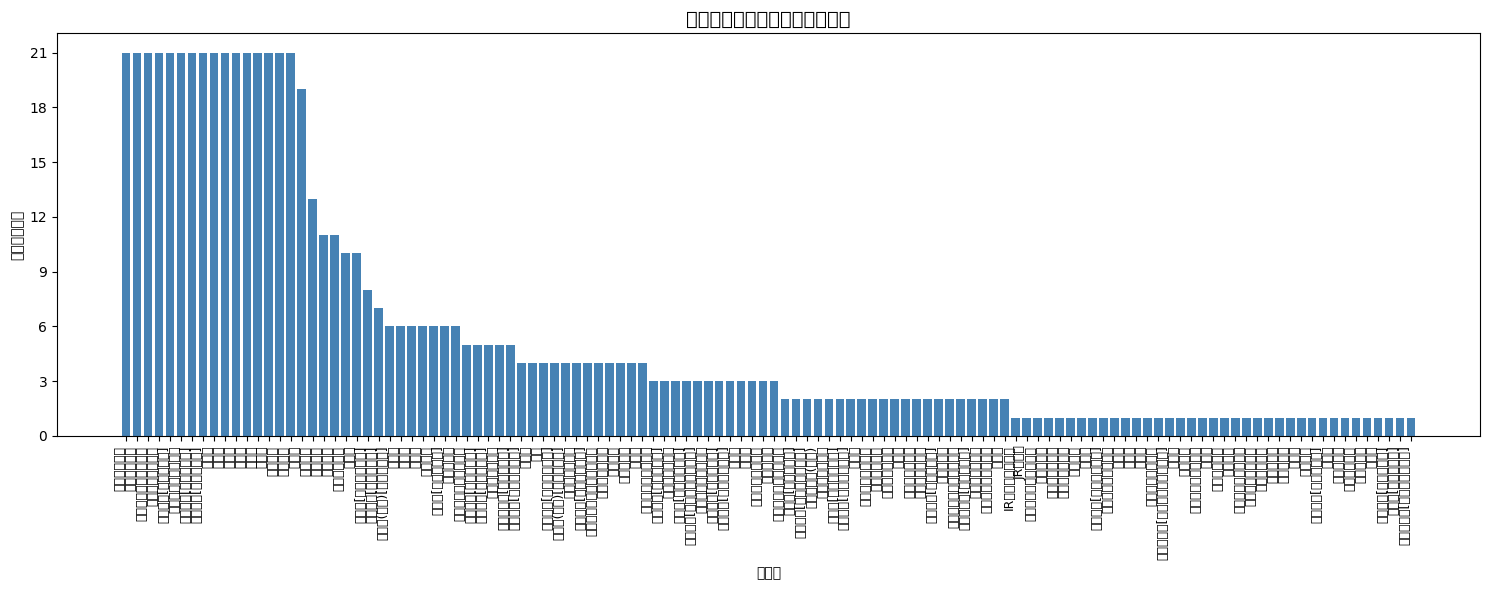

■ 路線別の異常発生回数一覧
路線: いすみ鉄道線 - 異常発生回数: 21
路線: くま川鉄道線 - 異常発生回数: 21
路線: 大井川鉄道大井川本線 - 異常発生回数: 21
路線: 天竜浜名湖鉄道線 - 異常発生回数: 21
路線: 奥羽本線[新庄～秋田] - 異常発生回数: 21
路線: 山万ユーカリが丘線 - 異常発生回数: 21
路線: 山陰本線[益田～下関] - 異常発生回数: 21
路線: 山陰本線[鳥取～益田] - 異常発生回数: 21
路線: 木次線 - 異常発生回数: 21
路線: 津軽線 - 異常発生回数: 21
路線: 米坂線 - 異常発生回数: 21
路線: 美祢線 - 異常発生回数: 21
路線: 肥薩線 - 異常発生回数: 21
路線: 赤穂線 - 異常発生回数: 21
路線: 陸羽東線 - 異常発生回数: 21
路線: 陸羽西線 - 異常発生回数: 21
路線: 岩徳線 - 異常発生回数: 19
路線: 熊本市電 - 異常発生回数: 13
路線: 九頭竜線 - 異常発生回数: 11
路線: 磐越西線 - 異常発生回数: 11
路線: 青い森鉄道線 - 異常発生回数: 10
路線: 飯山線 - 異常発生回数: 10
路線: 大糸線[松本～南小谷] - 異常発生回数: 8
路線: 羽越本線[酒田～秋田] - 異常発生回数: 7
路線: 中央線(快速)[東京～高尾] - 異常発生回数: 6
路線: 五能線 - 異常発生回数: 6
路線: 北上線 - 異常発生回数: 6
路線: 大湊線 - 異常発生回数: 6
路線: 宗谷本線 - 異常発生回数: 6
路線: 常磐線[品川～水戸] - 異常発生回数: 6
路線: 指宿枕崎線 - 異常発生回数: 6
路線: しなの鉄道北しなの線 - 異常発生回数: 5
路線: 奥羽本線[秋田～青森] - 異常発生回数: 5
路線: 山陽本線[三原～岩国] - 異常発生回数: 5
路線: 弘南鉄道大鰐線 - 異常発生回数: 5
路線: 東海道本線[東京～熱海] - 異常発生回数: 5
路線: 信越本線[直江津～新潟] - 異常発生回数: 4
路線: 内房線 - 異常発生回数: 4
路線: 呉線 - 異常発生回数: 4
路線: 宇都宮線[東京～宇都宮] - 異常発生回数: 4
路線: 常磐線(快速)[品川～取手

In [8]:
# 路線ごとの平常運転以外の件数をカウント
sql = """
SELECT line, COUNT(*) as count 
FROM train_data
WHERE status != '平常運転'
GROUP BY line 
ORDER BY count DESC
"""
abnormal_by_railway = pd.read_sql(sql, conn)

# グラフの作成
plt.figure(figsize=(15, 6))
plt.bar(abnormal_by_railway['line'], abnormal_by_railway['count'], color='steelblue')

plt.title('路線別の運転状況異常発生回数', fontsize=14)
plt.xlabel('路線名', fontsize=10)
plt.ylabel('異常発生回数', fontsize=10)

# x軸のラベルが重ならないよう回転させる
plt.xticks(rotation=90, ha='right', fontsize=9)

# y軸を適宜刻む
ymax = abnormal_by_railway['count'].max()
plt.yticks(range(0, int(ymax) + 3, 3))

# グリッドは使わない（デフォルトのスタイルは基本オフ）
plt.grid(False)

# レイアウトを自動調整して表示
plt.tight_layout()
plt.show()

# 路線名と異常発生回数を表示
print("■ 路線別の異常発生回数一覧")
for idx, row in abnormal_by_railway.iterrows():
    print(f"路線: {row['line']} - 異常発生回数: {row['count']}")

conn.close()

### 時間帯別異常発生回数

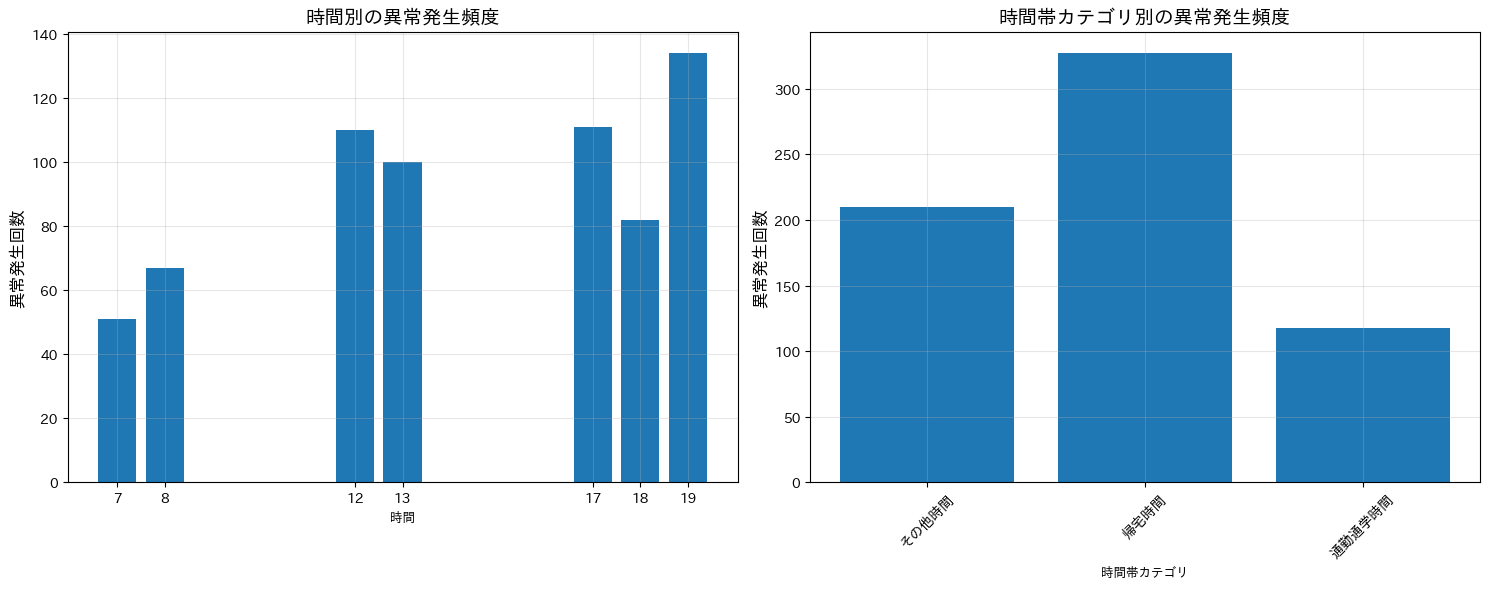


=== 時間帯ごとの詳細統計 ===

その他時間の統計:
12時: 110件
13時: 100件
小計: 210件

帰宅時間の統計:
17時: 111件
18時: 82件
19時: 134件
小計: 327件

通勤通学時間の統計:
7時: 51件
8時: 67件
小計: 118件


In [ ]:
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

def categorize_time(hour):
    if hour in [7, 8]:
        return '通勤通学時間'
    elif hour in [17, 18, 19]:
        return '帰宅時間'
    elif hour in [12, 13]:
        return 'その他時間'
    else:
        return '観測外'

sql = """
SELECT 
    CAST(strftime('%H', time) AS INTEGER) as hour,
    COUNT(*) as count
FROM train_data
WHERE status != '平常運転'
    AND CAST(strftime('%H', time) AS INTEGER) IN (7,8,12,13,17,18,19)
GROUP BY CAST(strftime('%H', time) AS INTEGER)
ORDER BY hour
"""
time_analysis = pd.read_sql(sql, conn)

time_analysis['time_category'] = time_analysis['hour'].apply(categorize_time)
category_analysis = time_analysis.groupby('time_category')['count'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(time_analysis['hour'], time_analysis['count'])
plt.title('時間別の異常発生頻度', fontsize=14)
plt.xlabel('時間', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.xticks([7,8,12,13,17,18,19])
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
plt.bar(category_analysis['time_category'], category_analysis['count'])
plt.title('時間帯カテゴリ別の異常発生頻度', fontsize=14)
plt.xlabel('時間帯カテゴリ', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 時間帯ごとの詳細な統計
print("\n=== 時間帯ごとの詳細統計 ===")
for category in category_analysis['time_category'].unique():
    print(f"\n{category}の統計:")
    hours = time_analysis[time_analysis['time_category'] == category]
    for _, row in hours.iterrows():
        print(f"{row['hour']}時: {row['count']}件")
    print(f"小計: {hours['count'].sum()}件")

conn.close()

### 都心と郊外の異常発生パターン

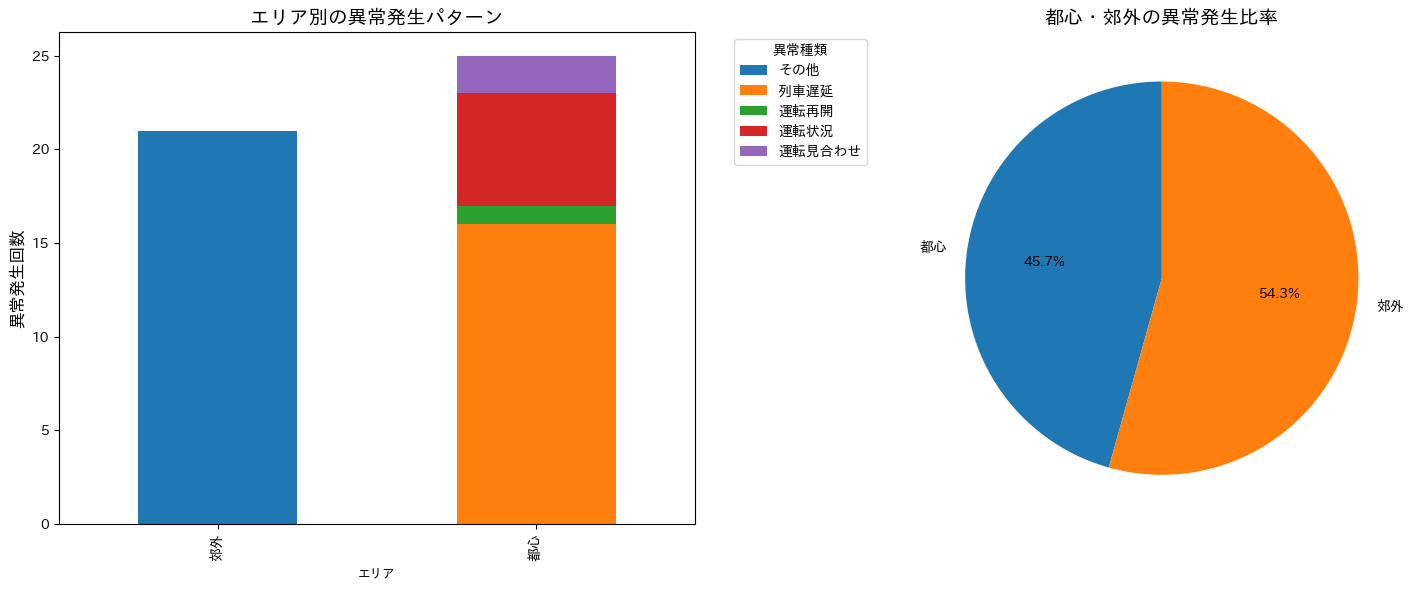


=== エリア別の異常発生統計 ===

都心の統計:
総異常発生件数: 25

異常種類別の内訳:
status
列車遅延      16
運転状況       6
運転見合わせ     2
運転再開       1
Name: count, dtype: int64

郊外の統計:
総異常発生件数: 21

異常種類別の内訳:
status
その他    21
Name: count, dtype: int64


In [ ]:
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

urban_rural_dict = {
    '都心': [
        '山手線', '中央線(快速)[東京～高尾]', '京浜東北根岸線', '東海道本線[東京～熱海]',
        '湘南新宿ライン', '横須賀線', '常磐線(快速)[品川～取手]', '総武線(快速)[東京～千葉]',
        '中央総武線(各停)'
    ],
    '郊外': [
        '北陸本線', '紀勢本線[和歌山～和歌山市]', '山陰本線[園部～鳥取]', '瀬戸大橋線[岡山～児島]', '木次線',
        '鳴門線', '山陽本線[下関～門司]', '鳴門線', '花咲線'
    ]
}

sql = """
SELECT 
    line,
    status,
    COUNT(*) as count
FROM train_data
WHERE status != '平常運転'
GROUP BY line, status
"""
area_analysis = pd.read_sql(sql, conn)

def categorize_area(line):
    for area, lines in urban_rural_dict.items():
        if line in lines:
            return area
    return 'その他'

area_analysis['area'] = area_analysis['line'].apply(categorize_area)
area_status_pivot = pd.pivot_table(
    area_analysis[area_analysis['area'].isin(['都心', '郊外'])],
    values='count',
    index='area',
    columns='status',
    aggfunc='sum',
    fill_value=0
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
area_status_pivot.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('エリア別の異常発生パターン', fontsize=14)
ax1.set_xlabel('エリア', fontsize=9)
ax1.set_ylabel('異常発生回数', fontsize=12)
ax1.legend(title='異常種類', bbox_to_anchor=(1.05, 1))
area_total = area_analysis[area_analysis['area'].isin(['都心', '郊外'])].groupby('area')['count'].sum()
ax2.pie(area_total, 
        labels=['都心', '郊外'],
        autopct='%1.1f%%',
        startangle=90)
ax2.set_title('都心・郊外の異常発生比率', fontsize=14)

plt.tight_layout()
plt.show()

# エリア別統計情報の出力
print("\n=== エリア別の異常発生統計 ===")
for area in ['都心', '郊外']:
    area_data = area_analysis[area_analysis['area'] == area]
    print(f"\n{area}の統計:")
    print(f"総異常発生件数: {area_data['count'].sum()}")
    print("\n異常種類別の内訳:")
    print(area_data.groupby('status')['count'].sum().sort_values(ascending=False))

conn.close()

### 異常発生パターン

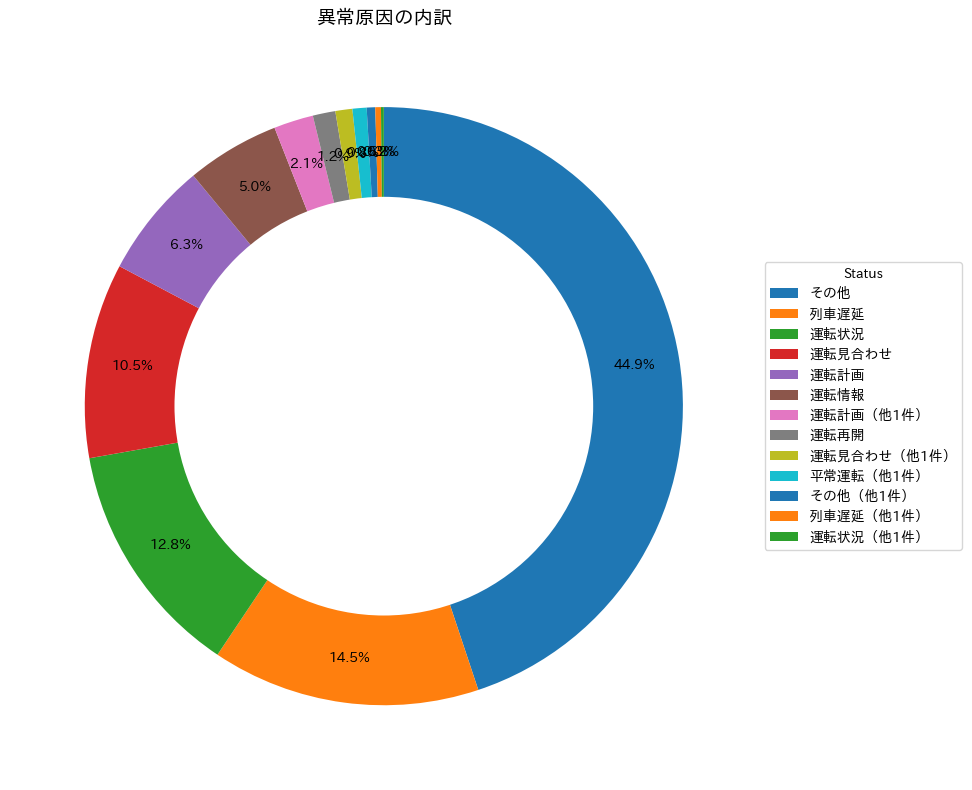

In [ ]:
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

sql_cause_analysis = """
SELECT
    status,
    COUNT(*) as count,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM train_data WHERE status != '平常運転') as percentage
FROM train_data
WHERE status != '平常運転'
GROUP BY status
ORDER BY count DESC
"""
cause_analysis = pd.read_sql(sql_cause_analysis, conn)

cause_analysis = cause_analysis.sort_values('percentage', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))  # サイズを調整
wedges, texts, autotexts = ax.pie(
    cause_analysis['percentage'], 
    autopct='%1.1f%%', 
    startangle=90,  # 12時の位置を開始位置にする
    pctdistance=0.85,
    counterclock=False,  # 時計回り
    textprops={'fontsize': 10}
)
ax.legend(wedges, cause_analysis['status'], title='Status', loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_title('異常原因の内訳', fontsize=14)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()


### 路線の重要度

<Figure size 1600x800 with 0 Axes>

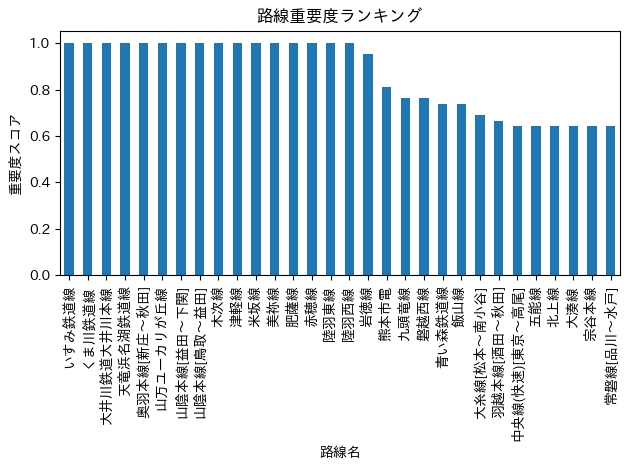

In [ ]:
sql_importance_analysis = """
SELECT
    line,
    COUNT(*) as abnormal_count,
    COUNT(DISTINCT DATE(time)) as affected_days
FROM train_data
WHERE status != '平常運転'
GROUP BY line
"""
importance_analysis = pd.read_sql(sql_importance_analysis, conn)

importance_analysis['score'] = (
    importance_analysis['abnormal_count'] / importance_analysis['abnormal_count'].max() +
    importance_analysis['affected_days'] / importance_analysis['affected_days'].max()
) / 2

plt.figure(figsize=(16, 8))
importance_analysis.nlargest(30, 'score').plot(x='line', y='score', kind='bar', legend=False)
plt.title('路線重要度ランキング')
plt.xlabel('路線名')
plt.ylabel('重要度スコア')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

conn.close()

/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/2389714734.py:36: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/2389714734.py:36: UserWarning: Glyph 22830 (\N{CJK UNIFIED IDEOGRAPH-592E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/2389714734.py:36: UserWarning: Glyph 32207 (\N{CJK UNIFIED IDEOGRAPH-7DCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/2389714734.py:36: UserWarning: Glyph 27494 (\N{CJK UNIFIED IDEOGRAPH-6B66}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls_d1j6q59gn37h9dj4_d00000gn/T/ipykernel_66968/2389714734.py:36: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4s/bgls

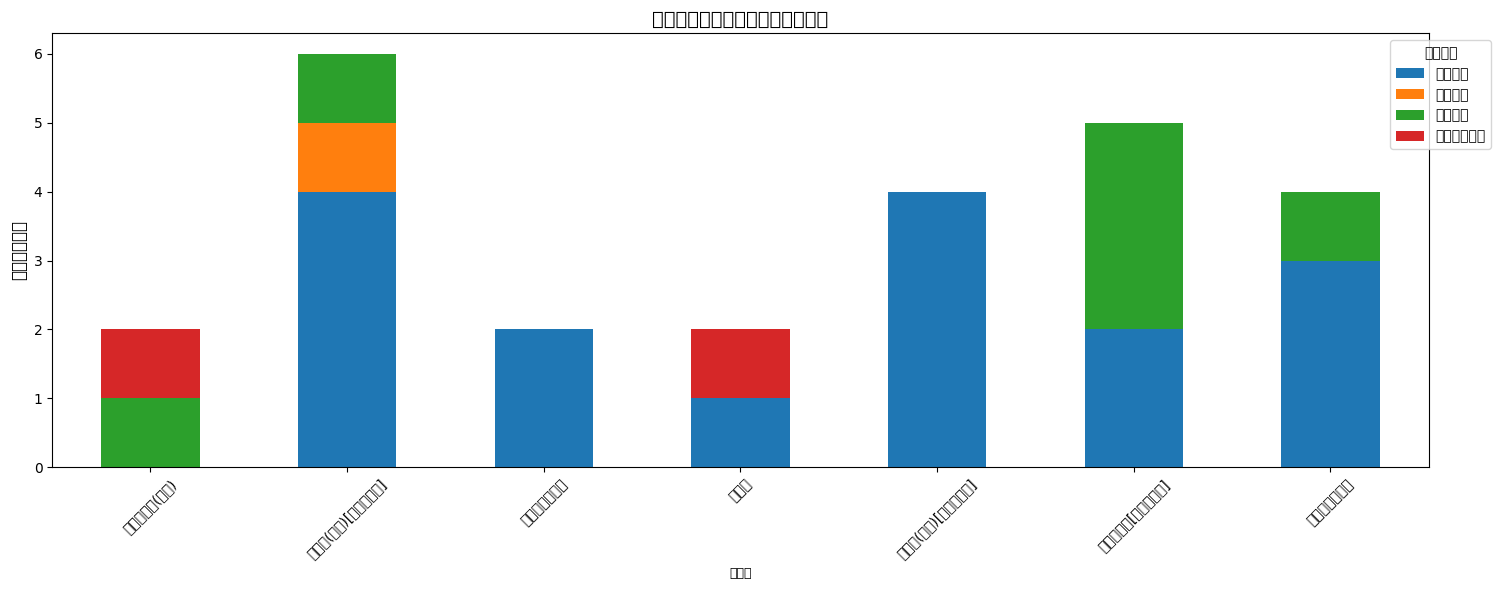

In [9]:
# 都心部での異常発生パターンを抽出して表示
db_name = 'train_info.db'
conn = sqlite3.connect(db_name)

sql_urban_analysis = """
SELECT
    line,
    status,
    COUNT(*) as count
FROM train_data
WHERE status != '平常運転'
    AND line IN (
        '山手線', '中央線(快速)[東京～高尾]', '京浜東北根岸線', '東海道本線[東京～熱海]',
        '湘南新宿ライン', '横須賀線', '常磐線(快速)[品川～取手]', '総武線(快速)[東京～千葉]',
        '中央総武線(各停)'
    )
GROUP BY line, status
"""
urban_analysis = pd.read_sql(sql_urban_analysis, conn)

urban_pivot = pd.pivot_table(
    urban_analysis,
    values='count',
    index='line',
    columns='status',
    aggfunc='sum',
    fill_value=0
)

urban_pivot.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('都心部の路線別異常発生パターン', fontsize=14)
plt.xlabel('路線名', fontsize=9)
plt.ylabel('異常発生回数', fontsize=12)
plt.legend(title='異常種類', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()